In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import dill

import numpy as np

import optbinning as opt
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score


In [2]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def metrics(fact, pred):
    plot_confusion_matrix(confusion_matrix(fact, pred > 0.5), ['0','1'])
    print('precision:', precision_score(fact, pred > 0.5))
    print('recall:', recall_score(fact, pred > 0.5))
    print('f1_score:', f1_score(fact, pred > 0.5))    
    print('roc_auc:', roc_auc_score(fact, pred))

## 1. Обработка ga_sessions.csv

### 1.1. Загрузка данных

In [39]:
df_sessions = pd.read_csv('d:/Python/SB/final_project/data/ga_sessions.csv')
# Оставим в датасете только id сессии, клиента и столбцы, необходимые по условиям задачи (типа utm_*, device_*, geo_*)
cols = df_sessions.columns
res_col = ['session_id', 'client_id']
for cl in cols:
    if cl[:4] in ('utm_', 'devi', 'geo_'):
        res_col.append(cl)

df_sessions = df_sessions[res_col]
df_sessions.head()

,session_id,client_id,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [4]:
# Посмотрим на размер датафрейма и на типы столбцов
df_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 15 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   utm_source                object
 3   utm_medium                object
 4   utm_campaign              object
 5   utm_adcontent             object
 6   utm_keyword               object
 7   device_category           object
 8   device_os                 object
 9   device_brand              object
 10  device_model              object
 11  device_screen_resolution  object
 12  device_browser            object
 13  geo_country               object
 14  geo_city                  object
dtypes: object(15)
memory usage: 212.9+ MB


### 1.2. Обработка пропусков и дублей

Missing Values: 4918396
В столбце utm_source пропущенных значений 97. Доля пропусков  0.01%
В столбце utm_campaign пропущенных значений 219603. Доля пропусков 11.81%
В столбце utm_adcontent пропущенных значений 335615. Доля пропусков 18.04%
В столбце utm_keyword пропущенных значений 1082061. Доля пропусков 58.17%
В столбце device_os пропущенных значений 1070138. Доля пропусков 57.53%
В столбце device_brand пропущенных значений 367178. Доля пропусков 19.74%
В столбце device_model пропущенных значений 1843704. Доля пропусков 99.12%
Duplicates in Data: 0


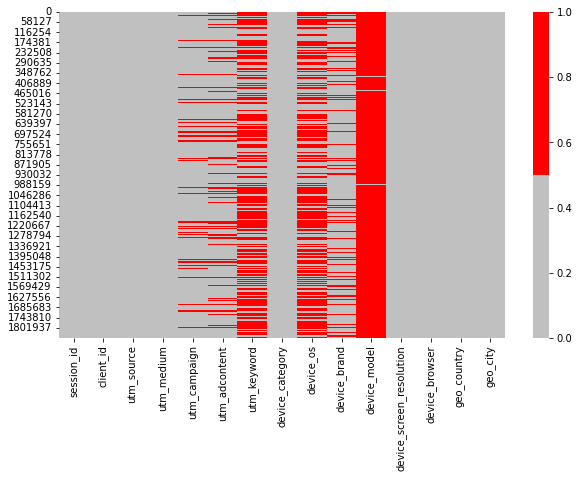

In [18]:
# Визуальная оценка наличия пропусков
# красный - пропущенные данные, серый - ок
plt.figure(figsize=(10,6))
sns.heatmap(df_sessions.isnull(), cmap=sns.color_palette(['#c0c0c0', '#ff0000']))


# Расчет количества и доли пропусков
miss = df_sessions.isna().sum().sum()
print('Пропущенные значения:', miss)

if miss > 0:
    for col in df_sessions.columns:
        miss = df_sessions[col].isna().sum()
        if miss > 0:
            print(f'В столбце {col} пропущенных значений {miss}. Доля пропусков {(miss/df_sessions.shape[0]*100):5.2f}%')

# Проверка наличия дубликатов в данных
print('Дубликаты:', df_sessions.duplicated().sum())

Дубликатов не обнаружено.

Много пропусков. Избавимся от них.
Попробуем разные методы:
1. замена наиболее часто встречающимся значением
2. удаление признаков с большой долей пропусков
3. введение отдельной категории для заполнения пропусков
4. попытка восстановить значения по значениям других признаков

##### В поле utm_source заменим пропуски на часто встречающееся значение

In [40]:
most_frequent_utm_source = df_sessions['utm_source'].mode()
impute_utm_source = SimpleImputer(strategy='most_frequent')
impute_utm_source.fit(df_sessions[['utm_source']])
df_sessions[['utm_source']] = impute_utm_source.transform(df_sessions[['utm_source']])

+ В столбце utm_campaign (рекламная кампания) пропущенных значений 219603. Доля пропусков 11.81%
+ В столбце utm_adcontent (не нашел в описании, что это за данные) пропущенных значений 335615. Доля пропусков 18.04%
+ В столбце utm_keyword пропущенных значений 1 082 061. Доля пропусков 58.17%

В боевых условиях для правильной обработки данных столбцов я бы поговорил с хозяином процесса.
Полагаю, что замена на часто встречающееся значение может быть ошибкой, так как, например, не все клиенты приходят в результате рекламной компании и незаполненное поле "utm_campaign" показывает отдельную категорию клиентов по данному признаку.

В данных полях заполню отсутствующие значения новой категорией "empty"


В полях device_brand и device_os так же заменим пропуски на empty, затем попытаемся частично восстановить значения по другим признакам.

In [41]:
impute_empty = SimpleImputer(strategy='constant', fill_value='empty')
col_for_empty = ['utm_campaign', 'utm_adcontent', 'utm_keyword', 'device_brand', 'device_os']
impute_empty.fit(df_sessions[col_for_empty])
df_sessions[col_for_empty] = impute_empty.transform(df_sessions[col_for_empty])

##### В поле device_brand попробуем восстановить значения по другим признакам. 

In [42]:
df_sessions['device_brand'].value_counts().head(10)

Apple        551088
empty        367178
Samsung      332194
Xiaomi       288367
Huawei       185853
Realme        19058
(not set)     17545
OPPO          13504
Vivo          11740
OnePlus        9965
Name: device_brand, dtype: int64

Кроме пустых значений в данном поле есть значения "not set".

В боевых условиях я выяснил бы как появляются такие значения и, в зависимости отрезультата рассматривал бы их либо как нормальные значения, либо как пропуски.

Сейчас исхожу из того, что это отдельная категория.

##### В поле device_brand попробуем восстановить значения по другим признакам

In [43]:
# Если device_browser == 'Safari' заполняем пропуски значением 'Apple' (более 41 000 записей)
df_sessions.loc[(df_sessions.device_brand == 'empty') & (df_sessions.device_browser == 'Safari'), 'device_brand'] = 'Apple'

# Если device_os == 'Macintosh' заполняем пропуски значением 'Apple' (более 11 318 записей)
df_sessions.loc[(df_sessions.device_brand == 'empty') & (df_sessions.device_os == 'Macintosh'), 'device_brand'] = 'Apple'

# Если device_browser == 'Samsung Internet' заполняем пропуски значением 'Samsung' (655 записей)
df_sessions.loc[(df_sessions.device_brand == 'empty') & (df_sessions.device_browser == 'Samsung Internet'), 'device_brand'] = 'Samsung'

##### В поле device_os попробуем восстановить значения по другим признакам.

In [44]:
df_sessions[['device_os']] = impute_empty.fit_transform(df_sessions[['device_os']])

# Если device_brand == 'Apple' заполняем пропуски значением 'iOS'
df_sessions.loc[(df_sessions.device_os == 'empty') & (df_sessions.device_brand == 'Apple'), 'device_os'] = 'iOS'

# Если ddevice_category.isin(['mobile', 'tablet']) заполняем пропуски значением 'Android'
df_sessions.loc[(df_sessions.device_os == 'empty') & (df_sessions.device_category.isin(['mobile', 'tablet'])), 'device_os'] = 'Android'
                                                      
# Если device_category == 'desktop' заполняем пропуски значением 'Windows'
df_sessions.loc[(df_sessions.device_os == 'empty') & (df_sessions.device_category == 'desktop'), 'device_os'] = 'Windows'                                                    

##### Удаляем поле с большим количеством пропусков:
+ В столбце device_model пропущенных значений 1843704. Доля пропусков 99.12%

In [45]:
df_sessions.drop('device_model', axis=1, inplace=True)

##### Убедимся, что пропусков не осталось

In [46]:
miss = df_sessions.isna().sum().sum()
print('Missing Values:', miss)

if miss > 0:
    for col in df_sessions.columns:
        miss = df_sessions[col].isna().sum()
        if miss > 0:
            print(f'В столбце {col} пропущенных значений {miss}. Доля пропусков {(miss/df_sessions.shape[0]*100):5.2f}%')

Missing Values: 0


## 2. Извлечение целевой переменной из ga_hits.csv
#### 2.1. Читаем файл

In [47]:
df_hits = pd.read_csv('d:/Python/SB/final_project/data/ga_hits.csv')
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [6]:
df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


#### 2.2 Проверяем количество уникальных сессий

In [48]:
print(df_hits.session_id.nunique())
df_hits.shape

1734610


(15726470, 11)

В файле ga_sessions.csv 1 860 042 записей
В файле ga_hits.csv есть записи только о 1 734 610 сессиях.
По 125 432 сессий нет записей о событиях.

В "боевых" уcловиях я бы поговорил со специалистами, обеспечивающими сбор данных и действовал в зависимости от причины:
* В ходе данных сессий не было никаких событий - присвоил им target=0.
* Информация об этих сессиях отсутствует по какой-либо причине:
    + План А найти информацию и дополнить датасет
    + План Б исключить их из дальнейшего рассмотрения

Для дальнейшей работы выбираю вариант с исключением данных сессий из рассмотрения.

#### 2.3. Сформируем целевой признак

In [49]:
df_hits['target'] = df_hits.event_action.isin(['sub_car_claim_click', 'sub_car_claim_submit_click',
                                               'sub_open_dialog_click', 'sub_custom_question_submit_click',
                                               'sub_call_number_click', 'sub_callback_submit_click',
                                               'sub_submit_success','sub_car_request_submit_click'])
pivot = df_hits.pivot_table(index="session_id", values="target", aggfunc=np.sum)

print(pivot.target.value_counts().head(10))

pivot['target'] = pivot['target'] > 0
pivot['target'].sum()

0    1683850
1      27406
3      11316
2       7006
4       2561
6        836
5        828
7        223
8        136
9        111
Name: target, dtype: int64


50760

## 3. Объединение даных в один датасет и его обработка
### 3.1. Объединение данных

In [50]:
df_full = df_sessions.merge(pivot, how='inner', on='session_id')

# Формируем таргет по клиенту
good_client = df_full[df_full.target == 1]['client_id']
df_full['target'] = df_full['client_id'].isin(good_client)

print('Размер датасета:', df_full.shape)
print('Записей с классом 1:', df_full.target.sum())
df_full.head()

Размер датасета: (1732266, 15)
Записей с классом 1: 127379


,session_id,client_id,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,False
1,905544597018549464.1636867290.1636867290,210838531.163687,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,False
2,9055446045651783499.1640648526.1640648526,2108385331.164065,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,False
3,9055447046360770272.1622255328.1622255328,2108385564.162225,kjsLglQLzykiRbcDiGcD,cpc,empty,NOBKLgtuvqYWkXQHeYWM,empty,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,False
4,9055447046360770272.1622255345.1622255345,2108385564.162225,kjsLglQLzykiRbcDiGcD,cpc,empty,empty,empty,mobile,Android,Xiaomi,393x786,Chrome,Russia,Moscow,False


Получено 1 732 266 записей.
Т.е. в файле ga_hits.csv есть записи о действиях, для которых нет соответствующих записей о сессиях в ga_sessions.csv.


В "боевых" условиях я провел бы расследование. Как минимум обсудил бы с хозяином данных возможные причины.

### 3.2. сформируем новые признаки 'organic_traffic' и 'social_media_advertising'

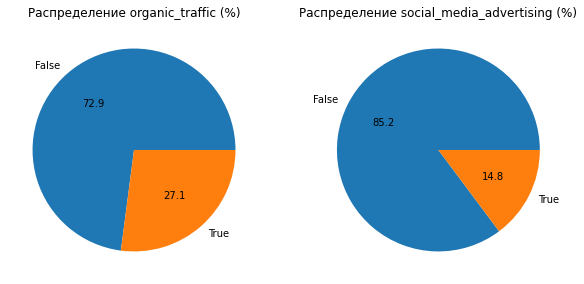

In [51]:
df_full['organic_traffic'] = df_full['utm_medium'].isin(['organic', 'referral', '(none)'])

df_full['social_media_advertising'] = df_full['utm_source'].isin(
    ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 
     'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'])

i = 1
plt.figure(figsize=(10,6))
for cl in ['organic_traffic', 'social_media_advertising']:
    stats = df_full.groupby([cl], as_index=False)[['session_id']].count()
    stats = stats.rename(columns={'session_id': 'count'})
    plt.subplot(1, 2, i)
    i += 1
    plt.pie(stats['count'], labels=stats[cl], autopct='%.1f')
    plt.title(f"Распределение {cl} (%)")
plt.show();

### Не запускать! Начало блока

In [52]:
# Сохраняем файл с таргетом по клиенту
df_full.to_csv('e:\df_full2.csv')

In [3]:
# работаем с таргетом по клиентам
df_full = pd.read_csv('e:\df_full2.csv')
df_full.rename(columns = {'Unnamed: 0' : 'Index'}, inplace = True)
df_full.set_index('Index', inplace=True)

### Не запускать! Конец блока

## 4. Моделирование

In [56]:
x_train, x_test, y_train, y_test = train_test_split(df_full.drop(['target', 'session_id', 'client_id'], axis=1), df_full['target'], test_size=0.3, random_state = 42)
cat_features = list(x_train.columns)
cat_features.remove('organic_traffic')
cat_features.remove('social_media_advertising')

### 4.1. Запустим модель с параметрами по умолчанию

0.8501910971969776 0.9394987242142001
0.8089571272124839 0.9349542025862069
precision: 0.8078697421981004
recall: 0.15529068099423593
f1_score: 0.26050622388484174
roc_auc: 0.8089571272124839
Wall time: 4min 48s


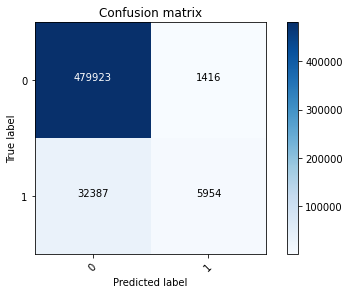

In [54]:
%%time
from catboost import CatBoostClassifier
model = CatBoostClassifier(    
    task_type="GPU",
    devices='0:1'
)
model.fit(
    x_train, y_train,
    cat_features=cat_features,
    verbose = False
)


train_pred = model.predict_proba(x_train)[:,1]
test_pred = model.predict_proba(x_test)[:,1]

print(roc_auc_score(y_train, train_pred), accuracy_score(y_train, train_pred>0.5))
print(roc_auc_score(y_test, test_pred), accuracy_score(y_test, test_pred>0.5))

metrics(y_test, test_pred)

Выводы:
+ Получены высокие ROC-AUC и  accuracy
+ Очень низкий recall - плохое распозначание класса "1" (менее 16% распознано правильно)
+ Высокий precision, почти все объекты класса "0" распознаны правильно
+ Такие результаты типичны для ситуации с сильным дисбалансом классов

В CatBoostClassifier параметр class_weights позволяет устранить эффект от дисбаланса. Попробую изменять его и посмотрю, как это повлияет на качество.

### 4.2. Подбор оптимального class_weights 

In [9]:
%%time

x_train, x_test, y_train, y_test = train_test_split(df_full.drop(['target', 'session_id', 'client_id'], axis=1), df_full['target'], test_size=0.3, random_state = 42)
cat_features = list(x_train.columns)
cat_features.remove('organic_traffic')
cat_features.remove('social_media_advertising')

results_train = pd.DataFrame(columns=['i', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
results_val = pd.DataFrame(columns=['i', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc'])

# Разбиваю train на тренировочные и валидационные, что бы не подбирать параметры на test
x_train_v, x_val, y_train_v, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)

for i in range(1, 21):
    model = CatBoostClassifier(
        class_weights = (1, i),
        task_type="GPU",
        devices='0:1'
    )
    
    model.fit(
        x_train_v, y_train_v,
        cat_features=cat_features,
        verbose = False
    )
    
    train_pred = model.predict_proba(x_train_v)[:,1]
    test_pred = model.predict_proba(x_val)[:,1]
    
    accuracy = accuracy_score(y_train_v, train_pred>0.5)
    precision = precision_score(y_train_v, train_pred>0.5)
    recall = recall_score(y_train_v, train_pred>0.5)
    f1 = f1_score(y_train_v, train_pred>0.5)    
    roc_auc = roc_auc_score(y_train_v, train_pred)
    
    results_train.loc[len(results_train.index)] = [i, accuracy, precision, recall, f1, roc_auc]    
    
    accuracy = accuracy_score(y_val, test_pred>0.5)
    precision = precision_score(y_val, test_pred>0.5)
    recall = recall_score(y_val, test_pred>0.5)
    f1 = f1_score(y_val, test_pred>0.5)    
    roc_auc = roc_auc_score(y_val, test_pred)
    results_val.loc[len(results_val.index)] = [i, accuracy, precision, recall, f1, roc_auc]
    
results_val['check'] = results_val['precision'] * results_val['recall'] * results_val['f1_score']
results_val['check'].max()
results_val[results_val['check'] == results_val['check'].max()]

Wall time: 1h 12min 21s


,i,accuracy,precision,recall,f1_score,roc_auc,check
4,5.0,0.905929,0.374758,0.398135,0.386093,0.808564,0.057607


In [15]:
results_val.drop('check', axis=1)

,i,accuracy,precision,recall,f1_score,roc_auc
0,1.0,0.933898,0.802864,0.146235,0.247406,0.804116
1,2.0,0.931716,0.608670,0.226761,0.330422,0.806824
2,3.0,0.924401,0.485774,0.298463,0.369749,0.807842
3,4.0,0.916192,0.422773,0.350297,0.383138,0.808219
4,5.0,0.905929,0.374758,0.398135,0.386093,0.808564
5,6.0,0.890627,0.328273,0.451190,0.380040,0.808628
6,7.0,0.872026,0.290204,0.499639,0.367155,0.808621
7,8.0,0.843921,0.251634,0.557578,0.346771,0.808430
8,9.0,0.816125,0.225917,0.607803,0.329398,0.808515
9,10.0,0.781468,0.202666,0.661579,0.310281,0.808535


Выводы:
+ ROC-AUC и  accuracy сохранены на высоком уровне
+ recall вырос, precision снизился, f1 вырос
+ пробовал запускать с разным параметром iterations, при этом меняется оптимальный class_weights

Если знать, для чего дальше будет применяться модель и понимать "цену" ошибочного распознавания каждого из классов, можно было бы настраивать модель на максимизацию precision или recall.

### 4.3. Feature Selection
Посмотрим на важность параметров и попробуем удалить те из них, предсказательная сила которых низкая.

Wall time: 1min 4s


Text(0.5, 1.0, 'Feature Importance')

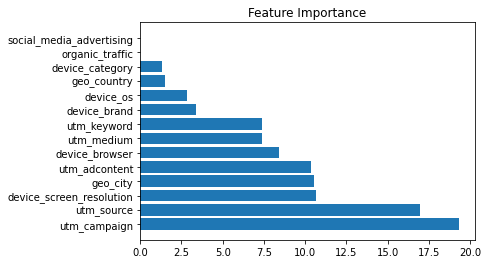

In [57]:
%%time

# Строим модель с оптимальным class_weights

from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=200,
    class_weights = (1, 5),
    task_type="GPU",
    devices='0:1'
)
model.fit(
    x_train, y_train,
    cat_features=cat_features,
    verbose = False
)

# Посмотрим на важность признаков
feature_importance = model.get_feature_importance(prettified=True)
plt.barh(feature_importance['Feature Id'], feature_importance['Importances'], align='center')
plt.title('Feature Importance')

precision: 0.3690487153513215
recall: 0.41809029498448136
f1_score: 0.3920417721364198
roc_auc: 0.8117226775004022


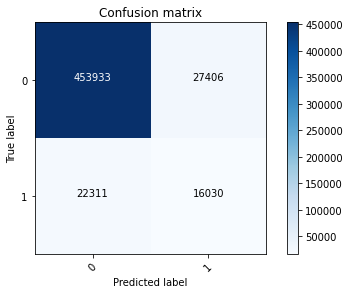

In [11]:
metrics(y_test, model.predict_proba(x_test)[:,1])

0.8583160036285205 0.9136679790134473
0.812569415254481 0.904364224137931
precision: 0.3699420641645103
recall: 0.42135051250619443
f1_score: 0.39397634434825024
roc_auc: 0.812569415254481
Wall time: 1min 6s


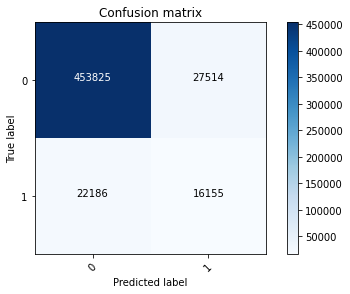

In [58]:
%%time

# Попробуем удалить признаки с низкой предсказательной силой и обучить модель

drop_col=['target', 'session_id', 'client_id']
short_cat_features = cat_features.copy()
for cl in list(feature_importance[feature_importance['Importances']<2]['Feature Id']):
    drop_col.append(cl)
    if cl in short_cat_features:
        short_cat_features.remove(cl)
        
x_train, x_test, y_train, y_test = train_test_split(df_full.drop(drop_col, axis=1), df_full['target'], test_size=0.3, random_state = 42)

from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=200,
    class_weights = (1, 5),
    task_type="GPU",
    devices='0:1'
)
model.fit(
    x_train, y_train,
    cat_features=short_cat_features,
    verbose = False
)


train_pred = model.predict_proba(x_train)[:,1]
test_pred = model.predict_proba(x_test)[:,1]

print(roc_auc_score(y_train, train_pred), accuracy_score(y_train, train_pred>0.5))
print(roc_auc_score(y_test, test_pred), accuracy_score(y_test, test_pred>0.5))

metrics(y_test, test_pred)

Выводы:

Качество модели из-за удаления признаков существенно не изменилось.
Можно продолжить эксперименты с удалением признаков, пока не найдем оптимальный набор по параметрам качество модели и время, затрачиваемое на обучение. Я пока останавливаюсь на этом, так как обучение проходит достаточно быстро.

### 4.4. Подбор параметров модели

In [78]:
x_train_v, x_val, y_train_v, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)

In [79]:
%%time
import optuna
import pandas as pd


def run_cb(trial):
    param = {
        "iterations": trial.suggest_int("iterations", 50, 500),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "class_weights": trial.suggest_categorical("class_weights", [(1, 5), (1, 8)]),
    }
    
   
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb_model = CatBoostClassifier(**param)
    
    cb_model.fit(
        x_train_v,
        y_train_v,
        cat_features=short_cat_features,
        early_stopping_rounds=100,        
        verbose=1000
    )
    
    preds = cb_model.predict_proba(x_val)[:, 1]
    score = roc_auc_score(y_val, preds)
    return score


cb_study = optuna.create_study(direction="maximize")
cb_study.optimize(run_cb, n_trials=50)

[I 2022-10-31 20:53:50,877] A new study created in memory with name: no-name-a7d1e640-c5d2-4346-8f0c-9fe9f4bc7deb


Learning rate set to 0.412337
0:	learn: 0.6283089	total: 244ms	remaining: 1m 47s
439:	learn: 0.5001492	total: 1m 42s	remaining: 0us


[I 2022-10-31 20:55:40,483] Trial 0 finished with value: 0.7664923938679538 and parameters: {'iterations': 440, 'colsample_bylevel': 0.04572961079862404, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 5), 'subsample': 0.3139830379342592}. Best is trial 0 with value: 0.7664923938679538.


Learning rate set to 0.414932
0:	learn: 0.5935951	total: 203ms	remaining: 1m 28s
436:	learn: 0.5004180	total: 50.6s	remaining: 0us


[I 2022-10-31 20:56:38,406] Trial 1 finished with value: 0.7659128382261763 and parameters: {'iterations': 437, 'colsample_bylevel': 0.05797506227855848, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 5), 'bagging_temperature': 5.751861396910568}. Best is trial 0 with value: 0.7664923938679538.


Learning rate set to 0.476268
0:	learn: 0.6214717	total: 111ms	remaining: 41.7s
375:	learn: 0.4862968	total: 51.2s	remaining: 0us


[I 2022-10-31 20:57:36,926] Trial 2 finished with value: 0.7813885948502245 and parameters: {'iterations': 376, 'colsample_bylevel': 0.026778013620535376, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 5), 'bagging_temperature': 4.955306314251874}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.5
0:	learn: 0.6168034	total: 80ms	remaining: 4.4s
55:	learn: 0.5011961	total: 3.71s	remaining: 0us


[I 2022-10-31 20:57:47,470] Trial 3 finished with value: 0.7635922057941453 and parameters: {'iterations': 56, 'colsample_bylevel': 0.08674995363296222, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 5), 'subsample': 0.5059361694694521}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.5
0:	learn: 0.6328180	total: 254ms	remaining: 48.1s
189:	learn: 0.5627420	total: 18s	remaining: 0us


[I 2022-10-31 20:58:12,189] Trial 4 finished with value: 0.7600903155966887 and parameters: {'iterations': 190, 'colsample_bylevel': 0.058514294160102925, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 8), 'bagging_temperature': 1.7882319610453479}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.5
0:	learn: 0.6738902	total: 103ms	remaining: 29.3s
285:	learn: 0.5623791	total: 30.5s	remaining: 0us


[I 2022-10-31 20:58:49,602] Trial 5 finished with value: 0.7624522251077572 and parameters: {'iterations': 286, 'colsample_bylevel': 0.01907712011732317, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.5
0:	learn: 0.6367058	total: 131ms	remaining: 19.3s
148:	learn: 0.5698598	total: 8.28s	remaining: 0us


[I 2022-10-31 20:59:04,843] Trial 6 finished with value: 0.7527881476480671 and parameters: {'iterations': 149, 'colsample_bylevel': 0.07044272045783878, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 8), 'bagging_temperature': 2.434969805278505}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.420226
0:	learn: 0.6274194	total: 110ms	remaining: 47.1s
430:	learn: 0.4952725	total: 47.1s	remaining: 0us


[I 2022-10-31 20:59:58,886] Trial 7 finished with value: 0.7716481833710584 and parameters: {'iterations': 431, 'colsample_bylevel': 0.024149592748318488, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 5), 'bagging_temperature': 1.176742521236045}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.5
0:	learn: 0.6224216	total: 78ms	remaining: 5.31s
68:	learn: 0.5231696	total: 6.41s	remaining: 0us


[I 2022-10-31 21:00:12,027] Trial 8 finished with value: 0.7357674876455846 and parameters: {'iterations': 69, 'colsample_bylevel': 0.03075726146117127, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 5)}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.5
0:	learn: 0.6224216	total: 77.3ms	remaining: 14.8s
192:	learn: 0.5130058	total: 16.9s	remaining: 0us


[I 2022-10-31 21:00:35,602] Trial 9 finished with value: 0.7488710733344623 and parameters: {'iterations': 193, 'colsample_bylevel': 0.03752234113056455, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 5), 'subsample': 0.5151844858062795}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.5
0:	learn: 0.6738902	total: 103ms	remaining: 32.7s
317:	learn: 0.5767101	total: 30.1s	remaining: 0us


[I 2022-10-31 21:01:12,370] Trial 10 finished with value: 0.7446826703802352 and parameters: {'iterations': 318, 'colsample_bylevel': 0.012333961812165298, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 8), 'bagging_temperature': 9.340340525142768}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.484546
0:	learn: 0.6206480	total: 109ms	remaining: 40s
368:	learn: 0.4902285	total: 48.4s	remaining: 0us


[I 2022-10-31 21:02:08,849] Trial 11 finished with value: 0.7781058574992039 and parameters: {'iterations': 369, 'colsample_bylevel': 0.028032119165541054, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 5), 'bagging_temperature': 5.320227270016279}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.498182
0:	learn: 0.6193219	total: 128ms	remaining: 45.8s
357:	learn: 0.4841828	total: 57.4s	remaining: 0us


[I 2022-10-31 21:03:14,147] Trial 12 finished with value: 0.7803836288947188 and parameters: {'iterations': 358, 'colsample_bylevel': 0.038654140978232714, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 5), 'bagging_temperature': 5.6905931893397685}. Best is trial 2 with value: 0.7813885948502245.


Learning rate set to 0.5
0:	learn: 0.6191479	total: 109ms	remaining: 38.2s
352:	learn: 0.4779440	total: 1m	remaining: 0us


[I 2022-10-31 21:04:22,058] Trial 13 finished with value: 0.7820061794384935 and parameters: {'iterations': 353, 'colsample_bylevel': 0.044423373003156255, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'class_weights': (1, 5), 'bagging_temperature': 7.671101772036302}. Best is trial 13 with value: 0.7820061794384935.


Learning rate set to 0.484546
0:	learn: 0.5831686	total: 187ms	remaining: 1m 8s
368:	learn: 0.4308382	total: 1m 31s	remaining: 0us


[I 2022-10-31 21:06:02,742] Trial 14 finished with value: 0.8006356726534231 and parameters: {'iterations': 369, 'colsample_bylevel': 0.04861606395748145, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'class_weights': (1, 5)}. Best is trial 14 with value: 0.8006356726534231.


Learning rate set to 0.377829
0:	learn: 0.5820162	total: 1.02s	remaining: 8m 13s
483:	learn: 0.3683834	total: 4m 31s	remaining: 0us


[I 2022-10-31 21:10:43,660] Trial 15 finished with value: 0.7943314217714236 and parameters: {'iterations': 484, 'colsample_bylevel': 0.07652345549883044, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'class_weights': (1, 5)}. Best is trial 14 with value: 0.8006356726534231.


Learning rate set to 0.375694
0:	learn: 0.5814655	total: 1.2s	remaining: 9m 41s
486:	learn: 0.3394401	total: 6m 1s	remaining: 0us


[I 2022-10-31 21:16:54,738] Trial 16 finished with value: 0.7871944783246749 and parameters: {'iterations': 487, 'colsample_bylevel': 0.09305488324728577, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'class_weights': (1, 5)}. Best is trial 14 with value: 0.8006356726534231.


Learning rate set to 0.368757
0:	learn: 0.5812002	total: 978ms	remaining: 8m 5s
496:	learn: 0.3732997	total: 4m 20s	remaining: 0us


[I 2022-10-31 21:21:24,100] Trial 17 finished with value: 0.796853939626741 and parameters: {'iterations': 497, 'colsample_bylevel': 0.07383417885324185, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'class_weights': (1, 5)}. Best is trial 14 with value: 0.8006356726534231.


Learning rate set to 0.5
0:	learn: 0.6155966	total: 678ms	remaining: 3m 2s
269:	learn: 0.5165314	total: 2m 56s	remaining: 0us


[I 2022-10-31 21:24:29,015] Trial 18 finished with value: 0.7996765729893796 and parameters: {'iterations': 270, 'colsample_bylevel': 0.07186898900766563, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 14 with value: 0.8006356726534231.


Learning rate set to 0.5
0:	learn: 0.6181834	total: 718ms	remaining: 2m 48s
235:	learn: 0.5208976	total: 1m 47s	remaining: 0us


[I 2022-10-31 21:26:23,466] Trial 19 finished with value: 0.7969977864501389 and parameters: {'iterations': 236, 'colsample_bylevel': 0.06499441700422029, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 14 with value: 0.8006356726534231.


Learning rate set to 0.5
0:	learn: 0.6061428	total: 1.55s	remaining: 6m 34s
255:	learn: 0.5152426	total: 3m 10s	remaining: 0us


[I 2022-10-31 21:29:41,833] Trial 20 finished with value: 0.8011316723442761 and parameters: {'iterations': 256, 'colsample_bylevel': 0.08159337489128006, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.5
0:	learn: 0.6061428	total: 1.56s	remaining: 7m 11s
276:	learn: 0.5172789	total: 3m 20s	remaining: 0us


[I 2022-10-31 21:33:09,901] Trial 21 finished with value: 0.798421240522367 and parameters: {'iterations': 277, 'colsample_bylevel': 0.0833118362035659, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.5
0:	learn: 0.6083872	total: 1.68s	remaining: 6m 30s
232:	learn: 0.5138275	total: 3m 58s	remaining: 0us


[I 2022-10-31 21:37:15,616] Trial 22 finished with value: 0.7985359538995287 and parameters: {'iterations': 233, 'colsample_bylevel': 0.09892827116534104, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.5
0:	learn: 0.6061428	total: 1.74s	remaining: 9m 15s
320:	learn: 0.5153922	total: 3m 52s	remaining: 0us


[I 2022-10-31 21:41:16,092] Trial 23 finished with value: 0.7992249341196735 and parameters: {'iterations': 321, 'colsample_bylevel': 0.08154450448985881, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.5
0:	learn: 0.6155966	total: 673ms	remaining: 2m 43s
243:	learn: 0.5229165	total: 1m 37s	remaining: 0us


[I 2022-10-31 21:43:00,866] Trial 24 finished with value: 0.7959217709478873 and parameters: {'iterations': 244, 'colsample_bylevel': 0.06698113258113164, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.5
0:	learn: 0.6367058	total: 155ms	remaining: 22s
142:	learn: 0.5690195	total: 13.3s	remaining: 0us


[I 2022-10-31 21:43:20,941] Trial 25 finished with value: 0.7539832553695867 and parameters: {'iterations': 143, 'colsample_bylevel': 0.05083245219206784, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.5
0:	learn: 0.6145246	total: 971ms	remaining: 5m 5s
314:	learn: 0.5180389	total: 2m 39s	remaining: 0us


[I 2022-10-31 21:46:07,744] Trial 26 finished with value: 0.7972113597862716 and parameters: {'iterations': 315, 'colsample_bylevel': 0.061210119085408306, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.448968
0:	learn: 0.6152124	total: 759ms	remaining: 5m 3s
400:	learn: 0.5215793	total: 2m 9s	remaining: 0us


[I 2022-10-31 21:48:25,480] Trial 27 finished with value: 0.7992526166040025 and parameters: {'iterations': 401, 'colsample_bylevel': 0.05280444794656316, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.5
0:	learn: 0.6176495	total: 661ms	remaining: 2m 12s
200:	learn: 0.5168623	total: 2m 23s	remaining: 0us


[I 2022-10-31 21:50:56,525] Trial 28 finished with value: 0.7991901814869456 and parameters: {'iterations': 201, 'colsample_bylevel': 0.09130764858129245, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'class_weights': (1, 8)}. Best is trial 20 with value: 0.8011316723442761.


Learning rate set to 0.5
0:	learn: 0.6738902	total: 221ms	remaining: 1m 3s
289:	learn: 0.5249553	total: 1m 44s	remaining: 0us


[I 2022-10-31 21:52:48,763] Trial 29 finished with value: 0.8017150833744008 and parameters: {'iterations': 290, 'colsample_bylevel': 0.07758475163349463, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.9920254251704617}. Best is trial 29 with value: 0.8017150833744008.


Learning rate set to 0.442895
0:	learn: 0.6754328	total: 208ms	remaining: 1m 24s
406:	learn: 0.5244172	total: 2m 27s	remaining: 0us


[I 2022-10-31 21:55:24,179] Trial 30 finished with value: 0.8021384861471716 and parameters: {'iterations': 407, 'colsample_bylevel': 0.07886646441959447, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.9494323394709483}. Best is trial 30 with value: 0.8021384861471716.


Learning rate set to 0.436991
0:	learn: 0.6756019	total: 208ms	remaining: 1m 25s
412:	learn: 0.5272113	total: 2m 20s	remaining: 0us


[I 2022-10-31 21:57:52,629] Trial 31 finished with value: 0.7989742655252889 and parameters: {'iterations': 413, 'colsample_bylevel': 0.07993029115440585, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.9939944447873995}. Best is trial 30 with value: 0.8021384861471716.


Learning rate set to 0.5
0:	learn: 0.6655800	total: 265ms	remaining: 1m 27s
329:	learn: 0.5290253	total: 2m 2s	remaining: 0us


[I 2022-10-31 22:00:02,642] Trial 32 finished with value: 0.7990797359574451 and parameters: {'iterations': 330, 'colsample_bylevel': 0.08933395419959012, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.9973295335406194}. Best is trial 30 with value: 0.8021384861471716.


Learning rate set to 0.455218
0:	learn: 0.6672650	total: 263ms	remaining: 1m 43s
394:	learn: 0.5184993	total: 3m 4s	remaining: 0us


[I 2022-10-31 22:03:15,082] Trial 33 finished with value: 0.8050867141742619 and parameters: {'iterations': 395, 'colsample_bylevel': 0.09685892742011099, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.807875274394537}. Best is trial 33 with value: 0.8050867141742619.


Learning rate set to 0.400662
0:	learn: 0.6695234	total: 260ms	remaining: 1m 57s
453:	learn: 0.5171094	total: 3m 43s	remaining: 0us


[I 2022-10-31 22:07:07,617] Trial 34 finished with value: 0.8064717697305204 and parameters: {'iterations': 454, 'colsample_bylevel': 0.09809113876865119, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.8207474842944953}. Best is trial 34 with value: 0.8064717697305204.


Learning rate set to 0.399855
0:	learn: 0.6695585	total: 265ms	remaining: 2m
454:	learn: 0.5172237	total: 3m 44s	remaining: 0us


[I 2022-10-31 22:11:00,840] Trial 35 finished with value: 0.8066727142966609 and parameters: {'iterations': 455, 'colsample_bylevel': 0.09913260833918994, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.8271233868169855}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.391962
0:	learn: 0.6699045	total: 292ms	remaining: 2m 15s
464:	learn: 0.5242819	total: 3m 22s	remaining: 0us


[I 2022-10-31 22:14:31,872] Trial 36 finished with value: 0.8026521850023742 and parameters: {'iterations': 465, 'colsample_bylevel': 0.09909692225195055, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.7691853547247134}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.393515
0:	learn: 0.6698360	total: 260ms	remaining: 2m
462:	learn: 0.5232076	total: 3m 17s	remaining: 0us


[I 2022-10-31 22:17:57,294] Trial 37 finished with value: 0.8045787869066099 and parameters: {'iterations': 463, 'colsample_bylevel': 0.09985061214057367, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.7398018767431878}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.396658
0:	learn: 0.6696981	total: 276ms	remaining: 2m 6s
458:	learn: 0.5299518	total: 2m 36s	remaining: 0us


[I 2022-10-31 22:20:40,994] Trial 38 finished with value: 0.7978027027167686 and parameters: {'iterations': 459, 'colsample_bylevel': 0.09485777010106758, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.7518412658123501}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.408929
0:	learn: 0.6691666	total: 260ms	remaining: 1m 55s
443:	learn: 0.5176877	total: 3m 12s	remaining: 0us


[I 2022-10-31 22:24:01,258] Trial 39 finished with value: 0.8065490486860031 and parameters: {'iterations': 444, 'colsample_bylevel': 0.08680257630435648, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.7766604109492751}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.416681
0:	learn: 0.6688367	total: 262ms	remaining: 1m 53s
434:	learn: 0.5192791	total: 3m 8s	remaining: 0us


[I 2022-10-31 22:27:17,505] Trial 40 finished with value: 0.8053840634725805 and parameters: {'iterations': 435, 'colsample_bylevel': 0.0855906547372952, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.8063261819315797}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.420226
0:	learn: 0.6686874	total: 260ms	remaining: 1m 51s
430:	learn: 0.5197541	total: 2m 59s	remaining: 0us


[I 2022-10-31 22:30:25,482] Trial 41 finished with value: 0.8051779855987505 and parameters: {'iterations': 431, 'colsample_bylevel': 0.08601471344914192, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.822069909591374}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.417562
0:	learn: 0.6687995	total: 258ms	remaining: 1m 51s
433:	learn: 0.5152993	total: 3m 21s	remaining: 0us


[I 2022-10-31 22:33:55,021] Trial 42 finished with value: 0.8042788225643296 and parameters: {'iterations': 434, 'colsample_bylevel': 0.08675441241797822, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.8441405250289253}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.408929
0:	learn: 0.6691666	total: 247ms	remaining: 1m 49s
443:	learn: 0.5178438	total: 3m 9s	remaining: 0us


[I 2022-10-31 22:37:12,868] Trial 43 finished with value: 0.8057380444111325 and parameters: {'iterations': 444, 'colsample_bylevel': 0.0861685430132139, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.6312563060679625}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.40558
0:	learn: 0.6693105	total: 254ms	remaining: 1m 53s
447:	learn: 0.5218105	total: 2m 55s	remaining: 0us


[I 2022-10-31 22:40:16,375] Trial 44 finished with value: 0.8032255075273601 and parameters: {'iterations': 448, 'colsample_bylevel': 0.08980240787874239, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.6048732045054565}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.464941
0:	learn: 0.6668862	total: 255ms	remaining: 1m 38s
385:	learn: 0.5144232	total: 3m 5s	remaining: 0us


[I 2022-10-31 22:43:29,977] Trial 45 finished with value: 0.8055244449950132 and parameters: {'iterations': 386, 'colsample_bylevel': 0.09432920604436161, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.6487738579760358}. Best is trial 35 with value: 0.8066727142966609.


Learning rate set to 0.464941
0:	learn: 0.6668862	total: 249ms	remaining: 1m 35s
385:	learn: 0.5127651	total: 3m 16s	remaining: 0us


[I 2022-10-31 22:46:54,488] Trial 46 finished with value: 0.8072549052531008 and parameters: {'iterations': 386, 'colsample_bylevel': 0.09412042370202543, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.6398116492462942}. Best is trial 46 with value: 0.8072549052531008.


Learning rate set to 0.384389
0:	learn: 0.6702410	total: 249ms	remaining: 1m 57s
474:	learn: 0.5143219	total: 3m 47s	remaining: 0us


[I 2022-10-31 22:50:50,207] Trial 47 finished with value: 0.8070820955539951 and parameters: {'iterations': 475, 'colsample_bylevel': 0.09115314715880857, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.6629806149837099}. Best is trial 46 with value: 0.8072549052531008.


Learning rate set to 0.383648
0:	learn: 0.6702741	total: 246ms	remaining: 1m 56s
475:	learn: 0.5706764	total: 1m 35s	remaining: 0us


[I 2022-10-31 22:52:32,575] Trial 48 finished with value: 0.7508814342674329 and parameters: {'iterations': 476, 'colsample_bylevel': 0.09299981622731374, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.6848375525438445}. Best is trial 46 with value: 0.8072549052531008.


Learning rate set to 0.369438
0:	learn: 0.6709181	total: 258ms	remaining: 2m 7s
495:	learn: 0.5136995	total: 4m 8s	remaining: 0us


[I 2022-10-31 22:56:50,236] Trial 49 finished with value: 0.8073644735803989 and parameters: {'iterations': 496, 'colsample_bylevel': 0.09465552587004872, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'class_weights': (1, 8), 'subsample': 0.9002441246234913}. Best is trial 49 with value: 0.8073644735803989.


Wall time: 2h 2min 59s


In [80]:
param = cb_study.best_params
param

{'iterations': 496,
 'colsample_bylevel': 0.09465552587004872,
 'depth': 8,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'class_weights': (1, 8),
 'subsample': 0.9002441246234913}

0.8584064415549224 0.8573123885646049
precision: 0.2535796172383136
recall: 0.56537388174539
f1_score: 0.35012315768221275
roc_auc: 0.8123042257899596
Wall time: 4min 1s


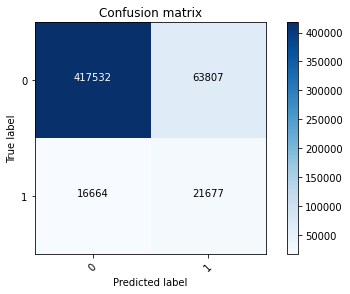

In [61]:
%%time

x_train, x_test, y_train, y_test = train_test_split(df_full.drop(drop_col, axis=1), df_full['target'], test_size=0.3, random_state = 42)


from catboost import CatBoostClassifier
model = CatBoostClassifier(**param)

model.fit(
    x_train, y_train,
    cat_features=short_cat_features,
    verbose = False
)


train_pred = model.predict_proba(x_train)[:,1]
test_pred = model.predict_proba(x_test)[:,1]

print(roc_auc_score(y_train, train_pred), accuracy_score(y_train, train_pred>0.5))

metrics(y_test, test_pred)

### Подберем оптимальный порог отсечения

In [ ]:
%%time
fr_train = pd.DataFrame(columns=['trsh', 'accuracy', 'precision', 'recall', 'f1'])
for trsh in np.arange(0.2, 0.8, 0.001):
    accuracy = accuracy_score(y_train, train_pred > trsh)
    precision = precision_score(y_train, train_pred > trsh)
    recall = recall_score(y_train, train_pred > trsh)
    f1 = f1_score(y_train, train_pred > trsh)    
    fr_train.loc[len(fr_train.index)] = [trsh, accuracy, precision, recall, f1]  

In [85]:
best_trsh = fr_train[fr_train.f1 == fr_train.f1.max()].trsh.iloc[0]
best_trsh

0.6720000000000004

[]

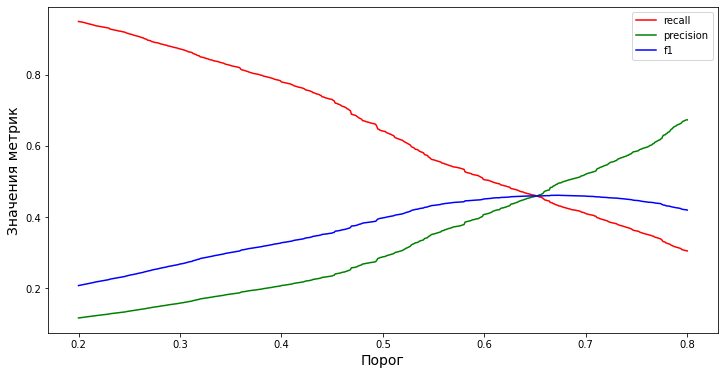

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(fr_train['trsh'], fr_train['recall'], color='r')
plt.plot(fr_train['trsh'], fr_train['precision'], color='g')
plt.plot(fr_train['trsh'], fr_train['f1'], color='b')
plt.legend(['recall', 'precision', 'f1'])
plt.xlabel('Порог', fontsize=14)
plt.ylabel('Значения метрик', fontsize=14)
plt.plot()

### Обчим модель с оптимальными параметрами на полном датасете и сохраним для использования в сервисе

precision: 0.28680123782755584
recall: 0.6344530888136977
f1_score: 0.3950308312335181
roc_auc: 0.8583247581564303
Wall time: 8min 51s


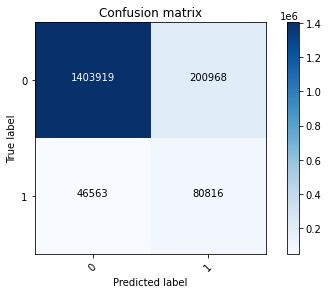

In [86]:
%%time
x = df_full.drop(['target', 'session_id', 'client_id'], axis=1)
y = df_full['target']

from catboost import CatBoostClassifier
model = CatBoostClassifier(**param)

model.fit(
    x, y,
    cat_features=cat_features,
    verbose = False
)

pred = model.predict_proba(x)[:,1]

metrics(y, pred)

In [87]:
full_model = {
    'model': model,
    'most_frequent_utm_source': most_frequent_utm_source,    
    'col_for_empty': col_for_empty,
    'best_trsh': best_trsh,
    'metadata': {        
        'name': 'target_action_predict',
        'author': 'Korob Vladimir',
        'version': '1.0',
        'date': datetime.now(),
        'type': 'CatBoostClassifier'
    }
}

with open('target_action_predict.pkl', 'wb') as file:
    dill.dump(full_model, file)